In [12]:
import MySQLdb, pickle
import pandas as pd
from sqlalchemy import create_engine
from collections import Counter

In [83]:
# read local car_info popular 
pw = pickle.load(open('./Data/pw.p','rb'))

db = MySQLdb.connect(
    "127.0.0.1",
    "root",
    '0',
    "car_info",
    charset='utf8',
)

SQL_QUERY = """
    SELECT *
    FROM car_info;
"""

train = pd.read_sql(SQL_QUERY, db)
train.head(20)

,index,year,title,company,subname,mile,photos,video,exterior_color,interior_color,transmission,drivetrain,star,review_no,vendor,price
0,0,2012,mercedes-benz c 250 luxury,mercedes-benz,c,65374,32,1,black,cappuccino,7-speed,rwd,5,10,southern auto brokers,12998
1,1,2005,porsche 911 carrera s cabriolet,porsche,911,64034,32,1,silver,stone gray,6-speed,rwd,5,11,united imports inc,30990
2,2,2010,mercedes-benz e 550,mercedes-benz,e,58204,32,1,iridium,black,7-speed,rwd,5,26,inetwork auto group,18549
3,3,2007,chevrolet avalanche lt w/3lt,chevrolet,avalanche,41631,27,1,summit,ebony light cashmere,4-speed,4wd,5,21,minton motor cars,17999
4,4,2016,volkswagen jetta 1.4t s,volkswagen,jetta,46042,25,1,cardinal,black,6-speed,fwd,5,18,hertz car sales winston-salem,9998
5,5,2017,kia sportage lx,kia,sportage,43989,26,1,sparkling,black,6-speed,fwd,5,18,hertz car sales winston-salem,14998
6,6,2017,chevrolet malibu 1lt,chevrolet,malibu,47450,25,1,cajun,jet black,6-speed,fwd,5,42,hertz car sales orlando,13988
7,7,2016,nissan sentra s,nissan,sentra,48058,25,1,gray,gray,6-speed,fwd,5,42,hertz car sales orlando,9988
8,8,2008,volvo v70 3.2,volvo,v70,169982,32,1,burgundy,tan,6-speed,fwd,5,16,sharpmotors,4750
9,9,2009,pontiac g8 gt,pontiac,g8,88919,27,1,silver,black,6-speed,rwd,5,8,ez choice auto sales,14999


In [84]:
company_list = []
for company in Counter(train.company).most_common(30):
    company_list.append(company[0])

In [90]:
idx_list = []
idx = 0
for i in train["company"]:
    if i not in company_list:
        idx_list.append(idx)
    idx += 1

In [92]:
train.shape

(4900, 16)

In [99]:
train = train.drop(idx_list)
train.reset_index(drop=True, inplace=True)
train = train.drop("index", axis=1)

Feature engineering

In [101]:
categorical_features = ['company', 'subname','transmission', 'drivetrain']

In [103]:
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,company_acura,company_audi,company_bmw,company_buick,company_cadillac,company_chevrolet,company_chrysler,company_dodge,company_ford,company_gmc,...,transmission_4-speed,transmission_5-speed,transmission_6-speed,transmission_7-speed,transmission_8-speed,transmission_9-speed,transmission_x-speed,drivetrain_4wd,drivetrain_fwd,drivetrain_rwd
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [104]:
numerical_features = ['year', 'mile', 'photos', 'star', 'review_no','price']

In [105]:
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,year,mile,photos,star,review_no,price
0,7.607381,11.087895,3.496508,1.791759,2.397895,9.472628
1,7.603898,11.067185,3.496508,1.791759,2.484907,10.341452
2,7.606387,10.971727,3.496508,1.791759,3.295837,9.828225
3,7.604894,10.636624,3.332205,1.791759,3.091042,9.798127
4,7.609367,10.737331,3.258097,1.791759,2.944439,9.210240


In [111]:
# pre_train = pd.merge(normalize_num, dummy_cat) 
X_train_0 = normalize_num.join(dummy_cat)
y_train = X_train_0["price"]
X_train = X_train_0.drop("price", axis=1)

In [136]:
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [139]:
clf = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [140]:
%time score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()

print("Score = {0:.5f}".format(score))

CPU times: user 221 ms, sys: 75.8 ms, total: 297 ms
Wall time: 2min 10s
Score = 0.85637


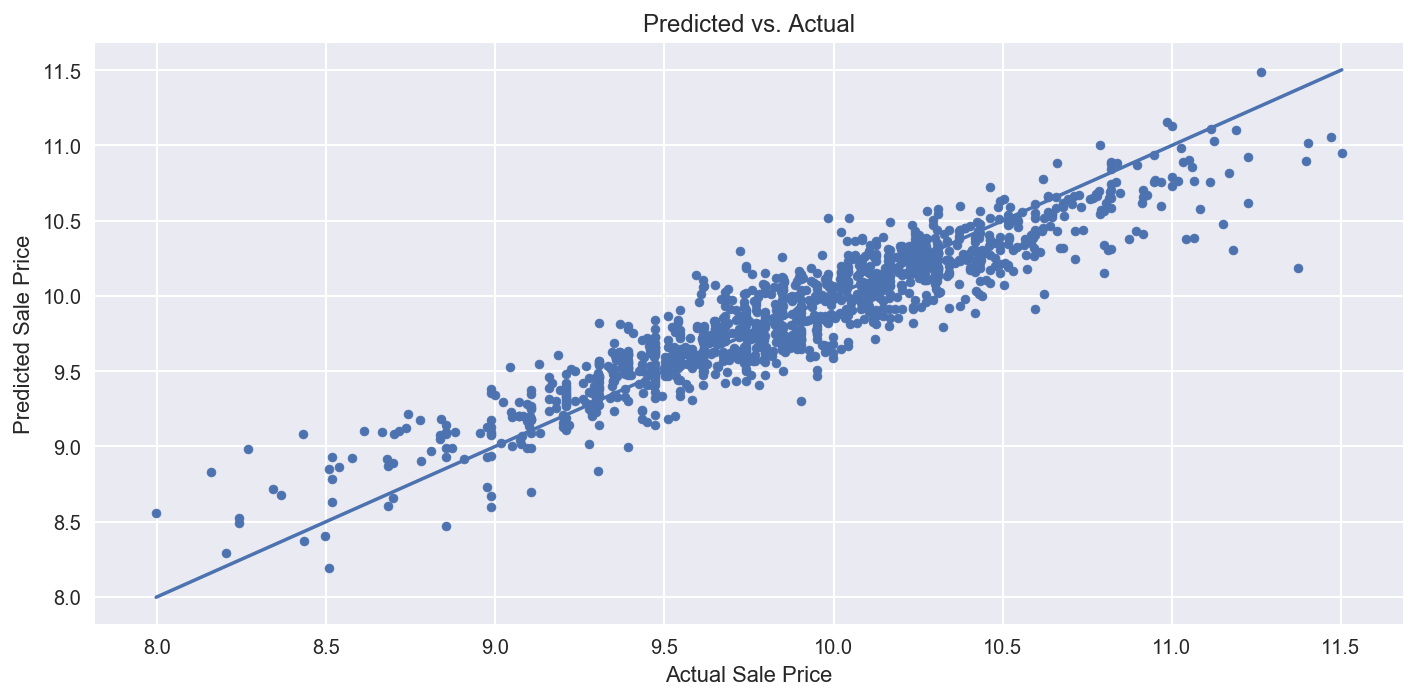

In [141]:
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()